<a href="https://colab.research.google.com/github/mukeshsinghmanral/Machine-Learning-practice/blob/main/Copy_of_sentiment_analysis_svm_nb_bagging_boosting_rf_lstm_17april_airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Twitter Sentiment Analysis With SVM, Naive Bayes, Bagging, Random Forest, And LSTM  </h1>

</div>
<p><img src = "https://www.vshsolutions.com/wp-content/uploads/2019/02/airlines.jpeg"  ></p>


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Importing Libraries </h1>
</div>


In [1]:
import pandas as pd
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df =pd.read_csv(r'https://raw.githubusercontent.com/mukeshsinghmanral/ML-lab/main/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

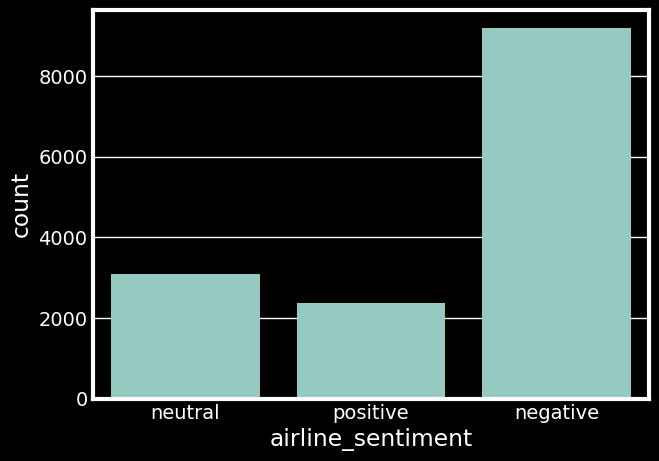

In [4]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

> Positive and neutral tweets are almost equal.

> Negative tweets are more than double of neutral or positive sentiments.

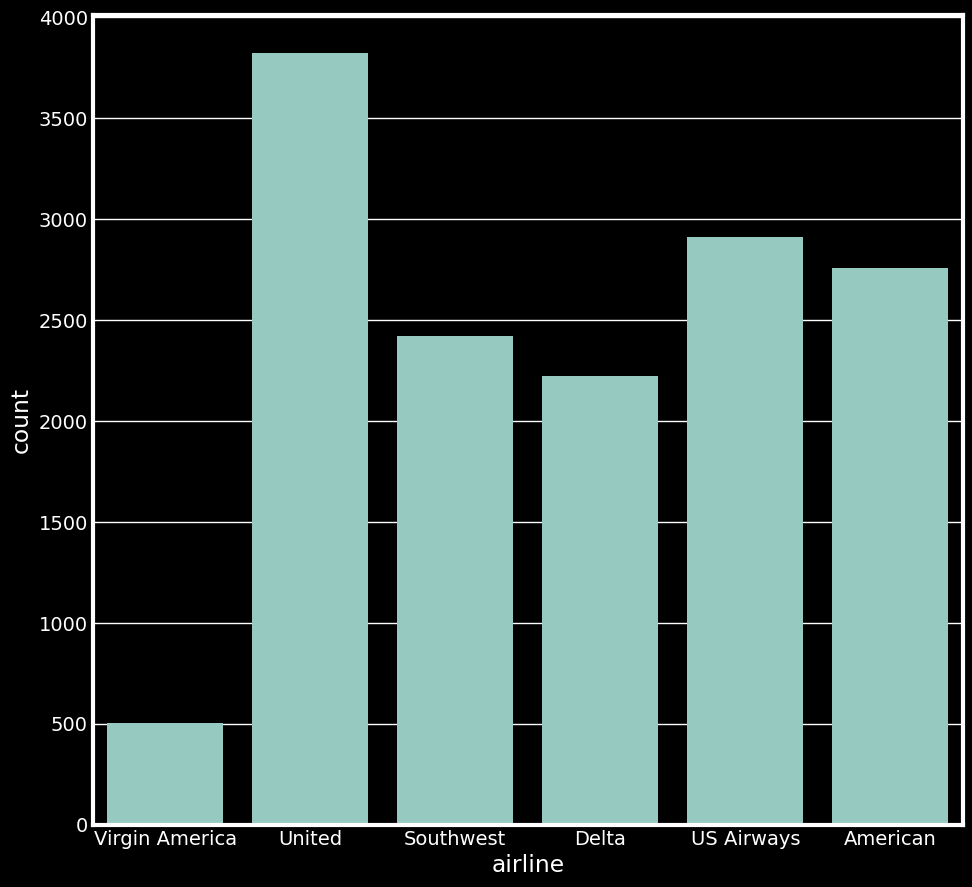

In [5]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

> United has the most number of flights.

> Virgin America has the least.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Utility Functions </h1>
</div>


In [6]:
# I am tokenizing the tweet and also taking tokens from second index onwards as initital to gives airline name and '@' and lowering thm and later making it back a sentence
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])



def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])



def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class))
  print()
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)

  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model



<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Text Preparation </h1>
</div>


In [7]:
# removing neutral tweets

df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [8]:
# Cleaning the tweets, removing punctuation marks
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),added commercials experience tacky
1,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
2,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
3,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay flight seats playing really bad thin...
4,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time fly vx ear worm go away


In [9]:
df['airline_sentiment'].unique()

array([1, 0])

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Base SVM model with TF-IDF </h1>
</div>


In [10]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)


Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863

Train ROC-AUC score:  0.9969059080962801
Test ROC-AUC score:  0.9291550477157531

Are under Precision-Recall curve: 0.6194895591647333
Area under ROC-AUC: 0.8049756920526223


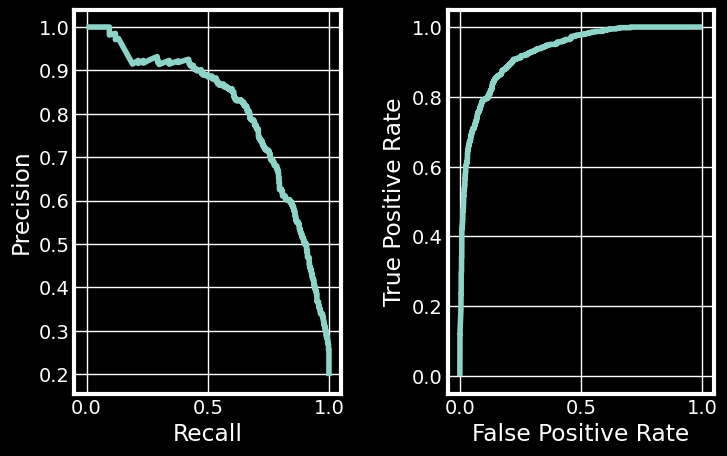

In [11]:

SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)


> With increase in FPR, TPR also increases.

> With increase in recall, precision decreases.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> After optimizing the hyperparameters with TF-IDF </h1>
</div>


In [12]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}



svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.2s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   6.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   6.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   6.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   6.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   4.8s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   5.3s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   4.3s
[CV] END ..................C=0.1, gamma=auto, ke

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2272   51]
 [ 245  318]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975

Train ROC-AUC score:  0.9987310154793744
Test ROC-AUC score:  0.9287241875782296

Are under Precision-Recall curve: 0.6824034334763949
Area under ROC-AUC: 0.8075412354680515


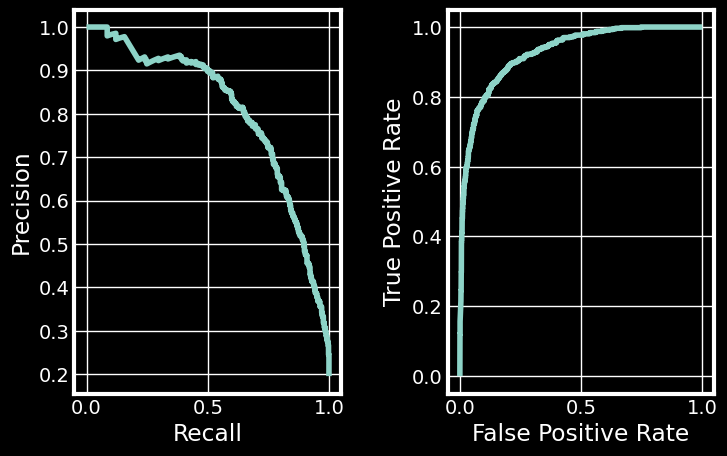

In [13]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

> With increase in recall, preciison decreases which makes sense also.

> With increase in TPR, FPR inceases.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Using Multinomial Naive Bayes </h1>
</div>


Train confusion matrix is: 
[[6853    2]
 [1296  504]]

Test confusion matrix is: 
[[2318    5]
 [ 474   89]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.8500288850375506
Test accuracy score:  0.834026334026334

Train ROC-AUC score:  0.9561105438041981
Test ROC-AUC score:  0.9013005324009118

Are under Precision-Recall curve: 0.2709284627092846
Area under ROC-AUC: 0.7374839454006489


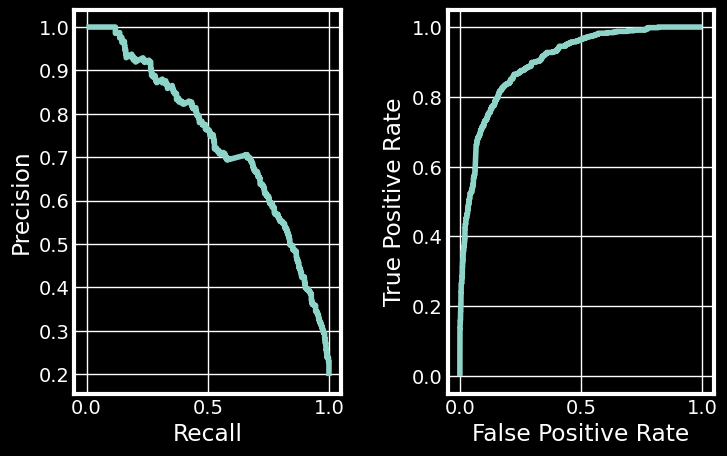

In [14]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Using Gaussian Naive Bayes
 </h1>
</div>


Train confusion matrix is: 
[[5543 1312]
 [   0 1800]]

Test confusion matrix is: 
[[1623  700]
 [ 181  382]]

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2323
           1       0.35      0.68      0.46       563

    accuracy                           0.69      2886
   macro avg       0.63      0.69      0.63      2886
weighted avg       0.79      0.69      0.72      2886


Train accuracy score:  0.8484113229347198
Test accuracy score:  0.6947331947331947

Train ROC-AUC score:  0.9043034281546316
Test ROC-AUC score:  0.688586755810495

Are under Precision-Recall curve: 0.4644376899696049
Area under ROC-AUC: 0.5471372315951626


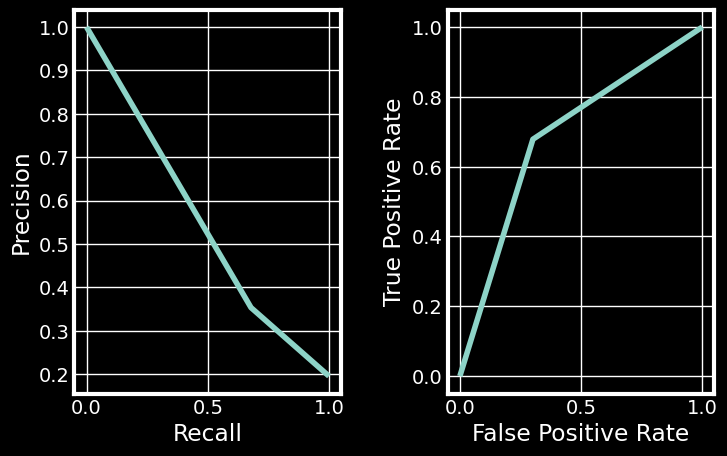

In [15]:
g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc=check_scores(GaussianNB(),x_train.toarray(), x_test.toarray(), y_train, y_test)


> It is interesting to see in Naive Bayes, we are getting linear relationship.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Using AdaBoost
 </h1>
</div>


> **base estimator here is: decision stump**

Train confusion matrix is: 
[[6655  200]
 [1012  788]]

Test confusion matrix is: 
[[2251   72]
 [ 328  235]]

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2323
           1       0.77      0.42      0.54       563

    accuracy                           0.86      2886
   macro avg       0.82      0.69      0.73      2886
weighted avg       0.85      0.86      0.84      2886


Train accuracy score:  0.8599653379549393
Test accuracy score:  0.8613998613998614

Train ROC-AUC score:  0.8689482940270687
Test ROC-AUC score:  0.8373803091947158

Are under Precision-Recall curve: 0.5402298850574713
Area under ROC-AUC: 0.6298876361965743


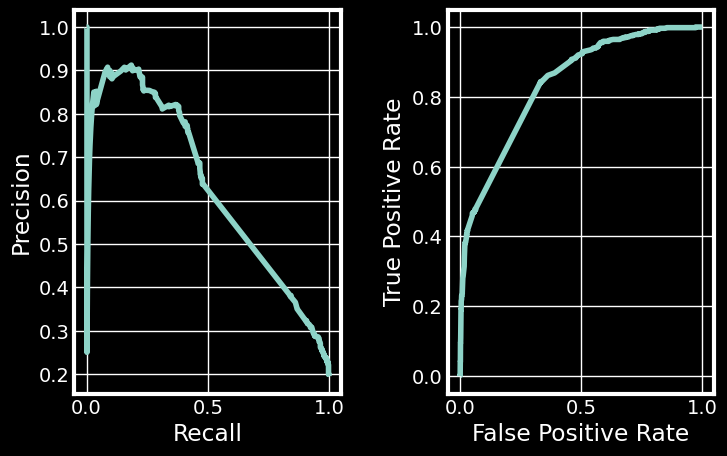

In [16]:
a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc=check_scores(AdaBoostClassifier(),x_train,x_test, y_train, y_test)


In [17]:
params = {'n_estimators': [10, 50, 100, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'algorithm': ['SAMME', 'SAMME.R']}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.5s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.5s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   2.9s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   1.9s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   5.1s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   5.0s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  21.5s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  20.4s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.7s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.7s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   2.1s
[CV] END algor

Train confusion matrix is: 
[[6761   94]
 [1043  757]]

Test confusion matrix is: 
[[2278   45]
 [ 340  223]]

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2323
           1       0.83      0.40      0.54       563

    accuracy                           0.87      2886
   macro avg       0.85      0.69      0.73      2886
weighted avg       0.86      0.87      0.85      2886


Train accuracy score:  0.868630849220104
Test accuracy score:  0.8665973665973666

Train ROC-AUC score:  0.9218550936056407
Test ROC-AUC score:  0.8779339205061136

Are under Precision-Recall curve: 0.5367027677496993
Area under ROC-AUC: 0.7021179688268547


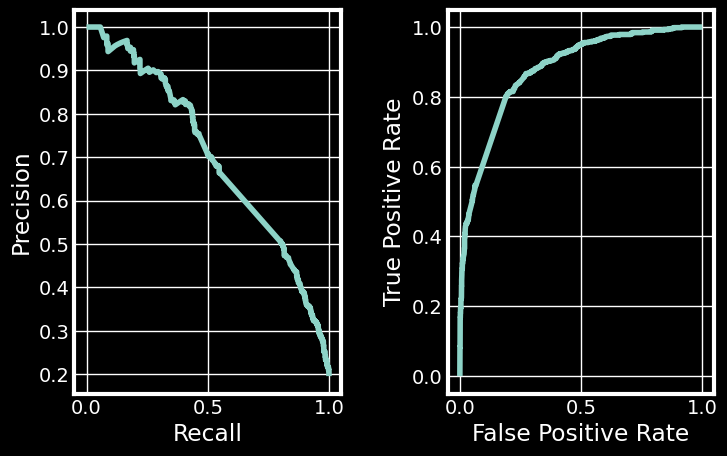

In [18]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Bagging with MultinomialNB
 </h1>
</div>


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train confusion matrix is: 
[[6853    2]
 [1314  486]]

Test confusion matrix is: 
[[2318    5]
 [ 475   88]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.847949162333911
Test accuracy score:  0.8336798336798337

Train ROC-AUC score:  0.9525075775994812
Test ROC-AUC score:  0.9002086632325291

Are under Precision-Recall curve: 0.2682926829268293
Area under ROC-AUC: 0.7346931021629801


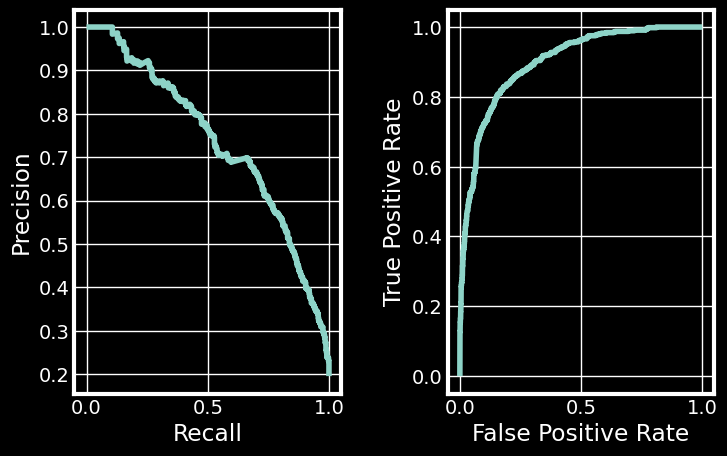

In [19]:


kfold = model_selection.KFold(n_splits = 3)

# bagging classifier
model = BaggingClassifier(base_estimator = MultinomialNB(),
                          n_estimators = 100)

b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc= check_scores(model,x_train,x_test, y_train, y_test)


# **Logistic Regression**

In [20]:
from sklearn.linear_model import LogisticRegression

def check_scores(model, x_train, x_test, y_train, y_test):
  # Train the logistic regression model
  model.fit(x_train, y_train)

  # Predict on train and test data
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)

  # Calculate accuracy for train and test data
  from sklearn.metrics import accuracy_score
  train_accuracy = accuracy_score(y_train, y_train_pred)
  test_accuracy = accuracy_score(y_test, y_test_pred)

  # Calculate AUC for train and test data (assuming binary classification)
  from sklearn.metrics import roc_auc_score
  train_auc = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
  test_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

  return train_accuracy, test_accuracy, train_auc, test_auc

# Example usage (assuming x_train, y_train, x_test, and y_test are defined)
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc = check_scores(LogisticRegression(random_state=0), x_train, x_test, y_train, y_test)

print("Train Accuracy:", r_train_accuracy)
print("Test Accuracy:", r_test_accuracy)
print("Train AUC:", r_train_auc)
print("Test AUC:", r_test_auc)


Train Accuracy: 0.8994800693240901
Test Accuracy: 0.8756063756063756
Train AUC: 0.9724908015236243
Test AUC: 0.9216996763387821


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Using Random Forest
 </h1>
</div>



In [21]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Using LSTM
 </h1>
</div>



In [22]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus]

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape


((11541, 124), (11541,))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


Epoch 1/10
121/121 [==============================] - 26s 195ms/step - loss: 0.4635 - accuracy: 0.7994 - val_loss: 0.3486 - val_accuracy: 0.8401
Epoch 2/10
121/121 [==============================] - 23s 189ms/step - loss: 0.2786 - accuracy: 0.8814 - val_loss: 0.2827 - val_accuracy: 0.8882
Epoch 3/10
121/121 [==============================] - 24s 196ms/step - loss: 0.2020 - accuracy: 0.9192 - val_loss: 0.3030 - val_accuracy: 0.8850
Epoch 4/10
121/121 [==============================] - 24s 201ms/step - loss: 0.1634 - accuracy: 0.9331 - val_loss: 0.3316 - val_accuracy: 0.8845
Epoch 5/10
121/121 [==============================] - 22s 180ms/step - loss: 0.1371 - accuracy: 0.9499 - val_loss: 0.3317 - val_accuracy: 0.8758
Epoch 6/10
121/121 [==============================] - 25s 204ms/step - loss: 0.1145 - accuracy: 0.9576 - val_loss: 0.4078 - val_accuracy: 0.8795
Epoch 7/10
121/121 [==============================] - 23s 189ms/step - loss: 0.0968 - accuracy: 0.9625 - val_loss: 0.4603 - val_ac

In [24]:
from tensorflow import keras


In [25]:
model_type = type(model)
print(f"Model type: {model_type}")

Model type: <class 'keras.src.engine.sequential.Sequential'>


In [26]:
if model_type == keras.models.Sequential:
    print("Model is a Sequential model.")
else:
    print("Model is not a Sequential model.")

Model is a Sequential model.


In [27]:
# Use the `model.predict` method instead of `model.predict_classes`
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Extract the class labels from the prediction probabilities
y_test_pred = np.argmax(y_test_pred, axis=1)
y_train_pred = np.argmax(y_train_pred, axis=1)

242/242 [==============================] - 6s 26ms/step


In [28]:
# y_test_pred=model.predict_classes(X_test)
# y_train_pred=model.predict_classes(X_train)a


In [29]:
test_acc_lstm = accuracy_score(y_test,y_test_pred)
train_acc_lstm = accuracy_score(y_train,y_train_pred)
test_roc_lstm = roc_auc_score(y_test,y_test_pred)
train_roc_lstm = roc_auc_score(y_train,y_train_pred)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Final Results
 </h1>
</div>




<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Conclusion
 </h1>
</div>

**Most of the models are doing pretty well here.**

In [30]:
data = [('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
 ('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('Bagged MultinomialNB',b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc ),
 ('AdaBoost',a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc ),
('AdaBoost Optimized',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc),
('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc),
('LSTM',train_acc_lstm, test_acc_lstm, train_roc_lstm, test_roc_lstm )]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
Random Forest,0.996418,0.880111,0.998244,0.895687
MultinomialNB,0.850029,0.834026,0.956111,0.901301
Bagged MultinomialNB,0.847949,0.833680,0.952508,0.900209
AdaBoost,0.859965,0.861400,0.868948,0.837380
AdaBoost Optimized,0.868631,0.866597,0.921855,0.877934
Gaussian Naive Bayes,0.848411,0.694733,0.904303,0.688587
SVM,0.978972,0.886348,0.996906,0.929155
SVM Optimized,0.996418,0.897436,0.998731,0.928724
LSTM,0.794232,0.797322,0.500000,0.500000


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/saved_model/model_inception.keras')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/saved_model/model_inception.keras'

In [33]:
import joblib

joblib.dump(model,'mymodel.h5')

['mymodel.h5']

In [34]:
import pickle

# Save the model to a file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Now the trained model is saved as 'trained_model.pkl' in the current directory
